# Recommendation Systems Assignment

### MIE 1513 UofT

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=8174c73bfb3ba43ee34450240f827a647d5915232544904bb37caee50b0501bb
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


## Support functions and variables

In [2]:
wget.download("https://github.com/MIE1513HS-2022/course-datasets/raw/main/ml-100k.zip", "ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [3]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [4]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [5]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [6]:
rating_df_train = getData(MOVIELENS_DIR, 'u1.base')
rating_df_test = getData(MOVIELENS_DIR, 'u1.test')

In [7]:
rating_df_train.head()

,userID,itemID,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [8]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [9]:
print("Number of users in rating df:", len(rating_df.userID.unique()))
print("Number of items in rating df:", len(rating_df.itemID.unique()))
print("Number of users in train df:", len(rating_df_train.userID.unique()))
print("Number of items in train df:", len(rating_df_train.itemID.unique()))
print("Number of users in test df:", len(rating_df_test.userID.unique()))
print("Number of items in test df:", len(rating_df_test.itemID.unique()))

Number of users in rating df: 943
Number of items in rating df: 1682
Number of users in train df: 943
Number of items in train df: 1650
Number of users in test df: 459
Number of items in test df: 1410


## Q1

### (a)

In [10]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    matrix = np.zeros((num_users,num_items),dtype = np.int8)
    
    for (index,userID,itemID,rating,timestamp) in rating_df.itertuples():
      matrix [userID-1,itemID-1] = rating
    
    
    ###########         end         ###########
    return matrix

In [11]:
dataPreprocessor(rating_df, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [12]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        for (user,item),rating in np.ndenumerate(train_matrix):
          #if rating == 0:
          userVector = train_matrix[user,:]
          ratedItems = userVector [userVector.nonzero()] # extract the itmes the user rated
          if ratedItems.size == 0:
            itemAvg = 0
          else:
            itemAvg = ratedItems.mean()
          predictionMatrix [user, item] = itemAvg
        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items): # iterate through each item-column
          # train_matrix [:, item] prints all the user rows at one particular item column
          #[0] has no actual meaning, but select the entire item's column (the second column)
          numOfUsersRated = len(train_matrix[:, item].nonzero()[0]) 
          numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
          if numOfUsersRated == 0:
            itemPopularity[item] = 0
          else:
            itemPopularity[item] = numOfUsersLiked/numOfUsersRated
          
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            #if rating == 0:
            predictionMatrix[user, item] = itemPopularity[item]

                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        self.__model = None

In [13]:
popularity_recsys = BaseLineRecSys('popularity')

In [14]:
popularity_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [15]:
x = popularity_recsys.getModel()

In [16]:
np.all(x<=1)

True

In [17]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [18]:
popularity_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:16, 1216.76it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


In [19]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [20]:
average_user_rating_recsys.predict_all(rating_df_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [21]:
average_user_rating_recsys.getModel()

array([[3.68148148, 3.68148148, 3.68148148, ..., 3.68148148, 3.68148148,
        3.68148148],
       [3.8       , 3.8       , 3.8       , ..., 3.8       , 3.8       ,
        3.8       ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [22]:
average_user_rating_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:05, 3932.90it/s]


,userID,itemID,rating,timestamp,useraverage
0,1,6,5,887431973,3.681481
1,1,10,3,875693118,3.681481
2,1,12,5,878542960,3.681481
3,1,14,5,874965706,3.681481
4,1,17,3,875073198,3.681481


## Q2

### (a)

In [23]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########
        similarity_matrix = pairwise_distances(matrix,metric = 'euclidean')
        similarity_matrix = 1/(1+similarity_matrix) # convert Euclidean distance to similarity score
        
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        Corr_d = pairwise_distances(matrix,metric ='correlation') # compute the correlation distance between the vectots
        similarity_matrix = abs(1-Corr_d)    

        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.__model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape) # tain_matrix: 943 x 1682
            temp_matrix[train_matrix.nonzero()] = 1 # set non-zeros to 1
            uu_similarity = self.method(train_matrix) # compute the similarity matrix
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5 # set 0 to 1e-5

            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            # Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            # output the predictionMatrix
            self.__model = predictionMatrix
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            train_matrix = train_matrix.T # redefine the train_matrix
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5 # set 0 to 1e-5

            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            # Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            # output/return the predictionMatrix
            self.__model = predictionMatrix.T
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        self.__model = None

In [24]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [25]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [26]:
SimBasedRecSys.somethingelse(I)

array([[1. , 0.5, 0.5],
       [0.5, 1. , 0.5],
       [0.5, 0.5, 1. ]])

Cosine similarity is preferred because even when two similar documents are far apart in terms of Euclidean distance (due to document size), they may still be closer together in orientation. The cosine similarity increases as the angle between the documents decreases.

### (b)

I would consider using correlation to measure similarity since it is not affected by the units used. For instance, if we scale one object by a factor of five, we would get different Euclidean distances, but the same correlation distances. Unlike cosine similarity, correlation is not affected by changes in the scale or location of x and y.

The code uses absolute correlation as a distance metric because the focus is on the strength of the relationship rather than its sign.

## Q3

### (a)

In [27]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [28]:
user_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [29]:
user_cosine_recsys.getModel()

array([[3.90764656, 3.18309825, 3.00989335, ..., 2.        , 3.        ,
        3.        ],
       [3.85592514, 3.18240388, 2.89077623, ..., 2.        , 3.        ,
        3.        ],
       [3.87394327, 3.10905007, 3.02102791, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.92534088, 3.20099215, 3.04206385, ..., 2.        , 3.        ,
        3.        ],
       [3.90921865, 3.21359819, 2.9819897 , ..., 2.        , 3.        ,
        3.        ],
       [3.93355541, 3.24681066, 3.05886723, ..., 0.        , 3.        ,
        3.        ]])

In [30]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [31]:
user_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:05, 3403.34it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,6,5,887431973,3.419572
1,1,10,3,875693118,3.850140
2,1,12,5,878542960,4.400558
3,1,14,5,874965706,3.878056
4,1,17,3,875073198,3.130335


In [32]:
#For item
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
item_cosine_recsys.getModel()

<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)


array([[3.85156994, 3.7342213 , 3.83843022, ..., 4.11798149, 3.90551101,
        3.9598337 ],
       [3.87401875, 3.85300753, 3.82228493, ..., 3.77601163, 3.95744705,
        4.09365253],
       [2.96947266, 3.03381501, 2.94253433, ..., 3.12417711, 3.27065656,
        2.79578581],
       ...,
       [4.11724041, 4.06618477, 4.0274836 , ..., 4.        , 3.88126854,
        4.14874911],
       [4.37234448, 4.42355222, 4.34195687, ..., 3.95265019, 4.41470077,
        4.57717283],
       [3.52291931, 3.4890315 , 3.53459055, ..., 0.        , 3.608216  ,
        3.59916709]])

In [33]:
item_cosine_recsys.evaluate_test(rating_df,copy=True)

100000it [00:55, 1798.67it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.376242
1,186,302,3,891717742,3.247784
2,22,377,1,878887116,2.911709
3,244,51,2,880606923,3.725628
4,166,346,1,886397596,3.534610
...,...,...,...,...,...
99995,880,476,3,880175444,3.509895
99996,716,204,5,879795543,3.989016
99997,276,1090,1,874795795,3.339578
99998,13,225,2,882399156,3.217582


### (b)

In [34]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
            'RPrecision': self.rprecision
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k 
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    def rprecision(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet = self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRPs = 0
        countRPs = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID, :]


            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID, :]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            topK = nlargest(len(userTestVector), range(len(userVector)), userVector.take)
            # Calculate recall
            rp = float(len([item for item in topK if item in userTestVector])) / len(userTestVector)

            # Update sum and count
            sumRPs += rp
            countRPs += 1

        # Return average R@k
        return float(sumRPs) / countRPs

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [35]:
# How to use CrossValidation Class?

In [36]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys]

In [37]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
cv_patk = CrossValidation('P@K')

In [38]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm popularity


20000it [00:05, 3828.05it/s]
20000it [00:05, 3941.04it/s]
20000it [00:07, 2845.10it/s]
20000it [00:05, 3850.58it/s]
20000it [00:05, 3949.98it/s]


Processing algorithm useraverage


20000it [00:05, 3426.18it/s]
20000it [00:04, 4009.58it/s]
20000it [00:05, 3854.62it/s]
20000it [00:05, 3602.18it/s]
20000it [00:04, 4044.73it/s]


Processing algorithm user-cosine


20000it [00:05, 3729.41it/s]
20000it [00:05, 3459.80it/s]
20000it [00:04, 4014.75it/s]
20000it [00:05, 3469.02it/s]
20000it [00:04, 4058.79it/s]


{'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943]}

In [39]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys, item_cosine_recsys]
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE
cv_patk = CrossValidation('RMSE')
# 3. Run CV by giving:
results_dict =  cv_patk.run(algorithm_instances, len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5).items()

Processing algorithm user-cosine


20000it [00:05, 3538.85it/s]
20000it [00:04, 4099.13it/s]
20000it [00:05, 3422.51it/s]
20000it [00:04, 4014.62it/s]
20000it [00:05, 3437.30it/s]


Processing algorithm item-cosine


<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:04, 4069.15it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:05, 3461.20it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:05, 3890.30it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:05, 3574.88it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:04, 4027.08it/s]


In [40]:
# print the results
for key, item in results_dict:
  print(key)
  print('5-Kfold CV socre:',item[0])
  print('Mean:',item[1])
  print('CI:',item[2:4])

user-cosine
5-Kfold CV socre: [1.026449013124381, 1.0214387664779507, 1.0132940326457187, 1.0094003999022947, 1.0161883961525586]
Mean: 1.0173541216605808
CI: [1.009013080226148, 1.0256951630950135]
item-cosine
5-Kfold CV socre: [1.0377631264364244, 1.0207280585350078, 1.0101820660011798, 1.0136832839209695, 1.0180579656376574]
Mean: 1.020082900106248
CI: [1.0068242686250732, 1.0333415315874226]


User-User similarity has a slightly better RMSE (1.017) compared to item-item (RMSE = 1.020). The reason for this is that the average number of ratings per user is greater than the average number of ratings per item. Consequently, there are more zero values for item ratings than for user ratings.

## Q4

### (a)

In [41]:
# 1. gather your algorithms in previous steps.
algorithm_instances_v2 = [popularity_recsys,average_user_rating_recsys,item_cosine_recsys, user_cosine_recsys]
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
metrics = ['RMSE','P@K','RPrecision']
#3. Run CV by giving:
Results = []
for m in metrics:
  cv_patk = CrossValidation(m)
  result = cv_patk.run(algorithm_instances_v2,len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)
  Results.append(result)

Processing algorithm popularity


20000it [00:05, 3520.84it/s]
20000it [00:05, 3961.73it/s]
20000it [00:05, 3399.54it/s]
20000it [00:04, 4078.65it/s]
20000it [00:05, 3449.56it/s]


Processing algorithm useraverage


20000it [00:06, 3278.89it/s]
20000it [00:04, 4017.66it/s]
20000it [00:05, 3415.44it/s]
20000it [00:10, 1848.65it/s]
20000it [00:05, 3408.82it/s]


Processing algorithm item-cosine


<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:04, 4020.86it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:05, 3409.15it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:04, 4051.42it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:05, 3382.73it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:05, 3942.98it/s]


Processing algorithm user-cosine


20000it [00:05, 3580.19it/s]
20000it [00:05, 3963.97it/s]
20000it [00:06, 3099.74it/s]
20000it [00:05, 3725.64it/s]
20000it [00:05, 3992.32it/s]


Processing algorithm popularity


20000it [00:05, 3665.39it/s]
20000it [00:06, 3303.27it/s]
20000it [00:05, 3706.42it/s]
20000it [00:05, 3821.18it/s]
20000it [00:05, 3457.60it/s]


Processing algorithm useraverage


20000it [00:04, 4033.30it/s]
20000it [00:05, 3727.30it/s]
20000it [00:04, 4073.70it/s]
20000it [00:04, 4107.02it/s]
20000it [00:04, 4031.04it/s]


Processing algorithm item-cosine


<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:05, 3353.41it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:08, 2447.25it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:07, 2617.07it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:05, 3958.07it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:05, 3406.99it/s]


Processing algorithm user-cosine


20000it [00:04, 4033.71it/s]
20000it [00:05, 3583.11it/s]
20000it [00:05, 3768.30it/s]
20000it [00:04, 4002.76it/s]
20000it [00:05, 3438.74it/s]


Processing algorithm popularity


20000it [00:04, 4042.40it/s]
20000it [00:05, 3788.98it/s]
20000it [00:05, 3560.22it/s]
20000it [00:11, 1777.75it/s]
20000it [00:04, 4013.02it/s]


Processing algorithm useraverage


20000it [00:05, 3437.25it/s]
20000it [00:04, 4002.31it/s]
20000it [00:05, 3807.42it/s]
20000it [00:04, 4034.06it/s]
20000it [00:06, 3301.62it/s]


Processing algorithm item-cosine


<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:04, 4055.80it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:07, 2826.34it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:04, 4046.58it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:05, 3491.25it/s]
<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
20000it [00:05, 3899.88it/s]


Processing algorithm user-cosine


20000it [00:04, 4002.55it/s]
20000it [00:05, 3482.51it/s]
20000it [00:04, 4027.86it/s]
20000it [00:05, 3400.23it/s]
20000it [00:06, 3165.62it/s]


In [42]:
# extract and organize the resutls
# position 0: 5 cv scores
# position 1: mean
# position 2: CI - lower bound
# position 3: CI - upper bouond

Methods_all = list(Results[0].keys())

length = len(metrics)
AVG_list =[]

for i in range(length):
  Mean_list = [] # reset the mean list under each metric
  for method in  Methods_all:
    Mean = Results [i][method][1]
    Mean_list.append(Mean)
  AVG_list.append(Mean_list)

In [43]:
# Print the average socres for each metric and algorithm
pd.DataFrame(AVG_list,columns = Methods_all,index = ['RMSE','P@K','RPrecision'])

,popularity,useraverage,item-cosine,user-cosine
RMSE,3.159093,1.043718,1.020083,1.017354
P@K,0.550583,0.473637,0.532216,0.555843
RPrecision,0.717666,0.645730,0.708014,0.721019


### (b)

RMSE cannot be used to assess popularity-based recommendations because popularity is not a prediction of the rating score (ranging from 1 to 5). Instead, it is the ratio of the number of people who gave high ratings to the total number of people who rated the item. Popularity is expressed as a value between 0 and 1. Therefore, we cannot measure it using RMSE, which calculates the error between the predicted and true scores. Ranking-based metrics are better suited to evaluate popularity-based recommendations.

# (c)
For RMSE, P@k and, RPrecision,  the best would likely be user-user cosine similarity. This is because user-user similarity is known to perform well in terms of accuracy and has been shown to outperform item-item similarity in many cases. Additionally, it can account for user preferences and biases, which can lead to better recommendations.

# (d)
A good RMSE performance may suggest better prediction accuracy or fewer errors, which could result in a better ranking. However, a good ranking score does not necessarily imply a good RMSE because ranking is based on the order of the items and not on the actual rating values.

## Q5

### (a)

In [44]:
# the follwoing code is directly copied from lab materials
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [45]:
moviesDF.sample(n = 3)

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
457,458,Nixon (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Nixon%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337,338,Bean (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Bean+(1997),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1373,1374,Falling in Love Again (1980),01-Jan-1980,NaN,http://us.imdb.com/M/title-exact?Falling%20in%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# Select the movies
moviesSelected = ['Careful (1992)','Mr. Smith Goes to Washington (1939)','Phenomenon (1996)']

In [47]:
# Extract the movie name 
Moive_name = moviesDF['movieTitle'].values
type(Moive_name)

numpy.ndarray

In [48]:
# Build a cosine similarity matrix
Rating_matrix = dataPreprocessor(rating_df,len(rating_df.userID.unique()), len(rating_df.itemID.unique())).T
Sim_matrix = SimBasedRecSys.cosine(Rating_matrix)
Sim_matrix_df = pd.DataFrame(Sim_matrix,columns = Moive_name,index = Moive_name)
Sim_matrix_df.head()

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),...,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
Toy Story (1995),1.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
GoldenEye (1995),0.402382,1.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
Four Rooms (1995),0.330245,0.273069,1.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
Get Shorty (1995),0.454938,0.502571,0.324866,1.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
Copycat (1995),0.286714,0.318836,0.212957,0.334239,1.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211


In [49]:
# print the top most similar movies for each chosen movie
for m in moviesSelected:
  print("The top 5 most similar movies for {} ".format(m))
  print(Sim_matrix_df[m].sort_values(ascending = False)[1:6],'\n')

The top 5 most similar movies for Careful (1992) 
Wend Kuuni (God's Gift) (1982)          1.0
Terror in a Texas Town (1958)           1.0
Lashou shentan (1992)                   1.0
Symphonie pastorale, La (1946)          1.0
Invitation, The (Zaproszenie) (1986)    1.0
Name: Careful (1992), dtype: float64 

The top 5 most similar movies for Mr. Smith Goes to Washington (1939) 
It's a Wonderful Life (1946)    0.542545
Gone with the Wind (1939)       0.502738
North by Northwest (1959)       0.485214
Notorious (1946)                0.472341
African Queen, The (1951)       0.471699
Name: Mr. Smith Goes to Washington (1939), dtype: float64 

The top 5 most similar movies for Phenomenon (1996) 
Independence Day (ID4) (1996)    0.624193
Ransom (1996)                    0.583163
Rock, The (1996)                 0.580936
Mission: Impossible (1996)       0.580100
Jerry Maguire (1996)             0.572837
Name: Phenomenon (1996), dtype: float64 



### (b)

The top 5 similar movies for the 3 chosen movies share similar category. For example, Mr. Smith Goes to Washington (1939) is a drama,romance,war film, all similar movies have common category with the movie.

In [50]:
# View the types of movie for each similar moive
filter_list = ["Mr. Smith Goes to Washington (1939)","It's a Wonderful Life (1946)","Gone with the Wind (1939)","North by Northwest (1959)","Notorious (1946)","African Queen, The (1951)"]
moviesDF[moviesDF.movieTitle.isin(filter_list)]

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
132,133,Gone with the Wind (1939),01-Jan-1939,NaN,http://us.imdb.com/M/title-exact?Gone%20with%2...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
135,136,Mr. Smith Goes to Washington (1939),01-Jan-1939,NaN,http://us.imdb.com/M/title-exact?Mr.%20Smith%2...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
479,480,North by Northwest (1959),01-Jan-1959,NaN,http://us.imdb.com/M/title-exact?North%20by%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
488,489,Notorious (1946),01-Jan-1946,NaN,http://us.imdb.com/M/title-exact?Notorious%20(...,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
495,496,It's a Wonderful Life (1946),01-Jan-1946,NaN,http://us.imdb.com/M/title-exact?It's%20a%20Wo...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,498,"African Queen, The (1951)",01-Jan-1951,NaN,http://us.imdb.com/M/title-exact?African%20Que...,0,1,1,0,0,...,0,0,0,0,0,1,0,0,1,0


## Q6

### (a)

In [51]:
# Select the userID and rating columns
# groupby the userID and find the counts (number of ratings) for each rating
# reset the index
new_df = rating_df[['userID','rating']].groupby('userID').count().reset_index()
new_df

,userID,rating
0,1,272
1,2,62
2,3,54
3,4,24
4,5,175
...,...,...
938,939,49
939,940,107
940,941,22
941,942,79


Text(0, 0.5, 'number of users')

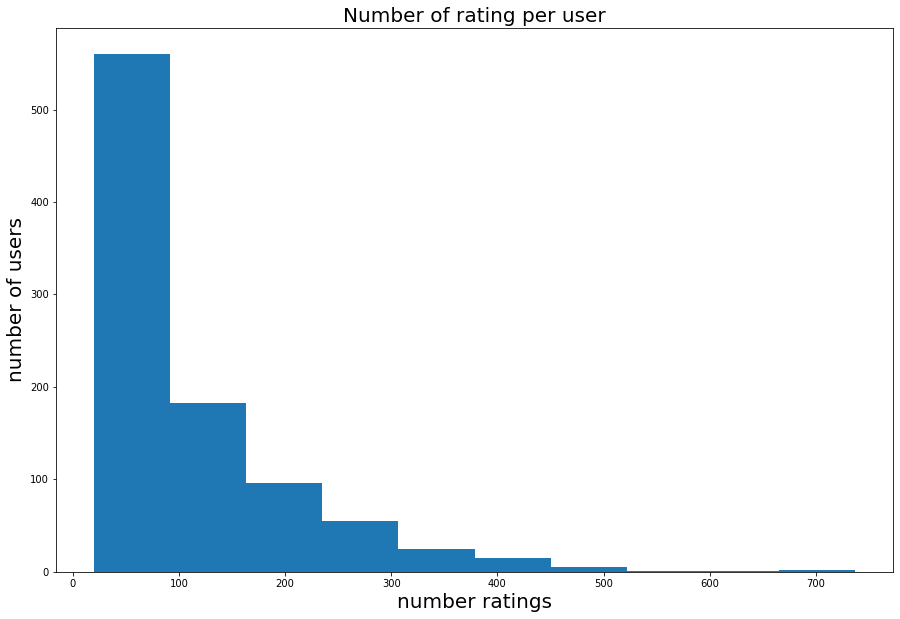

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,10))

plt.hist(new_df['rating'])
plt.title("Number of rating per user",fontsize=20)
plt.xlabel("number ratings",fontsize=20)
plt.ylabel("number of users",fontsize=20)

a threshold of 100 can distinguish users who have few ratings from those who have a moderate to large number of ratings.

In [53]:
threshold = 100
# Above the threshold
userID_above = new_df[new_df['rating'] >= threshold].userID.tolist()
# Bwlow the threshold
userID_below = new_df[new_df['rating'] < threshold].userID.tolist()

In [54]:
# Above the threshold data frame
userID_above_df = rating_df [rating_df['userID'].isin(userID_above)]
# Bwlow the threshold data frame
userID_below_df = rating_df [rating_df['userID'].isin(userID_below)]

In [55]:
def rmse(pred, test):
    # calculate RMSE for all the items in the test dataset
    predItems = pred[test.nonzero()].flatten() # return a copy of the array collapsed into one dimension
    testItems = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predItems, testItems))

In [56]:
# User - User (above threshold) prediction
user_User_above = SimBasedRecSys('user','cosine')
user_User_above.predict_all(userID_above_df, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
user_User_above.getModel() # get the prediction matrix
Y_pred_user_up = user_User_above.evaluate_test(userID_above_df,copy=True)
#Y_pred_user_up.iloc[:,4]

<ipython-input-23-0ec7e3620852>:90: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
74522it [00:31, 2386.42it/s]


In [57]:
# User - User (Below Threshold) prediction
user_User_below = SimBasedRecSys('user','cosine')
user_User_below.predict_all(userID_below_df, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
user_User_below.getModel() # get the prediction matrix
Y_pred_user_below = user_User_below.evaluate_test(userID_below_df,copy=True)


<ipython-input-23-0ec7e3620852>:90: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
25478it [00:07, 3342.55it/s]


In [58]:
# Item to item (Above Threshold)
item_item_above = SimBasedRecSys('item','cosine')
item_item_above.predict_all(userID_above_df, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
item_item_above.getModel() # get the prediction matrix
Y_pred_item_up = item_item_above.evaluate_test(userID_above_df,copy=True)

<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
74522it [00:30, 2414.74it/s]


In [59]:
# Item to item (Below Threshold)
item_item_below = SimBasedRecSys('item','cosine')
item_item_below.predict_all(userID_below_df, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
item_item_below.getModel() # get the prediction matrix
Y_pred_item_below = item_item_below.evaluate_test(userID_below_df,copy=True)

<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
25478it [00:07, 3249.94it/s]


In [60]:
# View the rmse with different user types
print ("RMSE for user-user above threshold:",rmse(Y_pred_user_up.iloc[:,4].values,Y_pred_user_up['rating'].values))

print ("RMSE for user-user below threshold:",rmse(Y_pred_user_below.iloc[:,4].values,Y_pred_user_below['rating'].values))

print ("RMSE for item-item above threshold: ",rmse(Y_pred_item_up.iloc[:,4].values,Y_pred_item_up['rating'].values))

print ("RMSE for item-item below threshold:",rmse(Y_pred_item_below.iloc[:,4].values,Y_pred_item_below['rating'].values))

RMSE for user-user above threshold: 0.9481767606298663
RMSE for user-user below threshold: 0.8901312664100373
RMSE for item-item above threshold:  0.9946094755385316
RMSE for item-item below threshold: 0.8942223431150697


For both user-user and item-item collaborative filtering, the performance is improved when the threshold is exceeded because there are more ratings available to train the model, leading to better results.

### (b)

# Validation

In [61]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [62]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [63]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [64]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [65]:
validatePopularityRecSys()

### User Average Based Recommendation

In [66]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [67]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [68]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [69]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [70]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [71]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [72]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [73]:
validateUUSimBasedRecSys()

<ipython-input-23-0ec7e3620852>:90: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)


### Item-Item Similarity Based Recommendation System

In [74]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        item_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        item_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = item_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [75]:
validateIISimBasedRecSys()

<ipython-input-23-0ec7e3620852>:110: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
